In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import numpy as np
import pickle as pkl
import pandas as pd
import os
from scipy.signal import argrelextrema
from scipy.signal import gaussian
from scipy.stats import pearsonr
from scipy.stats import binom_test
import seaborn as sns
import itertools as it
from scipy.misc import comb
import fnmatch
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import kstest
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import ranksums

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [4]:
rrrList  = [os.path.join(item[0],item[1]) for item in locate('*.rrr')]

In [5]:
R_s = np.array([])
for item in rrrList:
    R_s = np.append(R_s,pkl.load(open(item,'rb')))

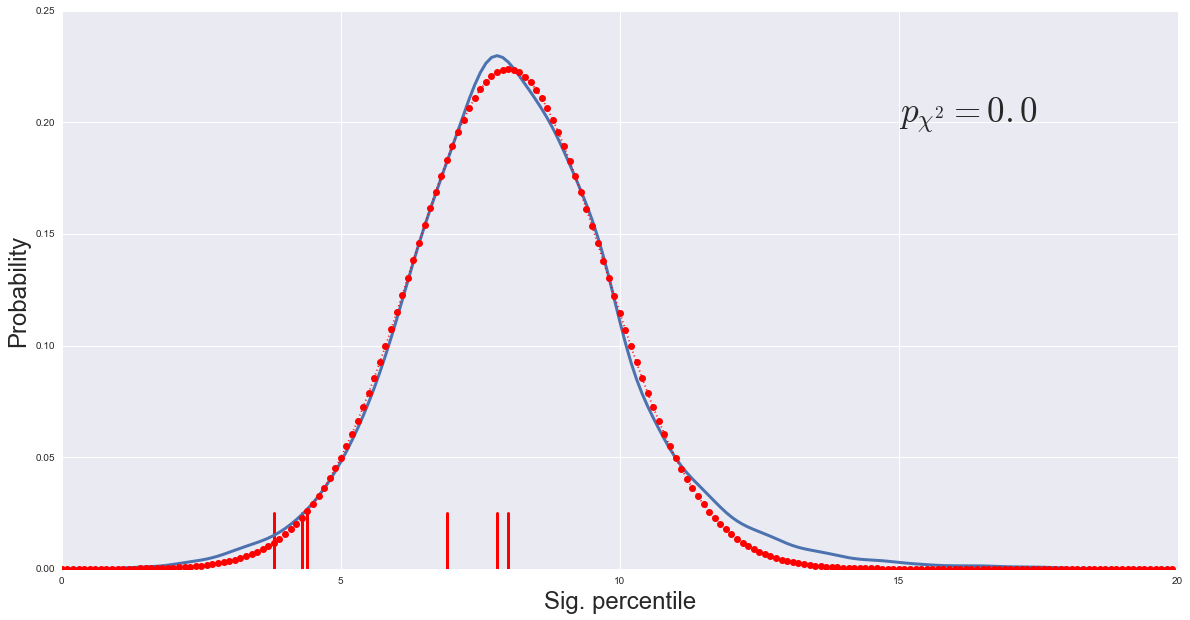

In [11]:
f,ax = pl.subplots(1,1,figsize=[20,10])
dens = sm.nonparametric.KDEUnivariate(R_s)
dens.fit('gau', bw='scott', gridsize=100, cut=3, clip=[0,100])
x = np.arange(0,20,0.1)
y = dens.evaluate(np.arange(0,20,0.1))
pl.axvline(3.8,linewidth=3,color='r',ymax=0.1)
pl.axvline(4.3,linewidth=3,color='r',ymax=0.1)
pl.axvline(4.4,linewidth=3,color='r',ymax=0.1)
pl.axvline(6.9,linewidth=3,color='r',ymax=0.1)
pl.axvline(7.8,linewidth=3,color='r',ymax=0.1)
pl.axvline(8.0,linewidth=3,color='r',ymax=0.1)
ax.text(15, 0.2, r'$p_{\chi^{2}}=0.0$', fontsize=35)
pl.ylabel('Probability',fontsize=24)
pl.xlabel('Sig. percentile',fontsize=24)
pl.plot(x,y,lw=3)
pl.plot(x,gaus(x,*popt),'ro:',label='fit')

In [7]:
n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = np.sqrt(sum(y*(x-mean)**2)/n)        #note this correction
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

In [14]:
a  = np.array([3.8,4.3,4.4,6.9,7.8,8.0,13.0])
aZ = (a-popt[1])/popt[-1]
print chisquare(aZ)

Power_divergenceResult(statistic=-32.121086551894706, pvalue=1.0)


In [15]:
popt,pcov

(array([ 0.22390587,  7.99875403,  1.72993097]),
 array([[  7.24675758e-07,   2.72740123e-13,  -3.73265427e-06],
        [  2.72740123e-13,   5.76783791e-05,  -2.21430905e-12],
        [ -3.73265427e-06,  -2.21430905e-12,   5.76783800e-05]]))

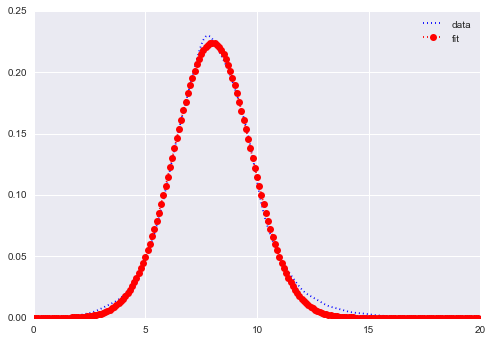

In [16]:
pl.plot(x,y,'b+:',label='data')
pl.plot(x,gaus(x,*popt),'ro:',label='fit')
pl.legend()

In [17]:
print kstest(aZ,'norm')
print ttest_1samp(aZ,0)

KstestResult(statistic=0.40982184977604652, pvalue=0.14109865248654518)
Ttest_1sampResult(statistic=-0.91721358702661593, pvalue=0.39440369779965201)


In [147]:
kt = 0
kks = 0
krs = 0
for ii in np.arange(1e4):
    rvs = np.random.normal(loc=popt[1],scale=popt[2],size=a.size)
    pt = ttest_ind(a,rvs)[1]
    pks = st.ks_2samp(a,rvs)[1]
    prs = st.wilcoxon(a,rvs)[1]
    if pt > 5e-2:
        kt+=1
    if pks>5e-2:
        kks+=1
    if prs>5e-2:
        krs+=1
print kt/1e2,kks/1e2, krs/1e2

59.56 88.68 64.37


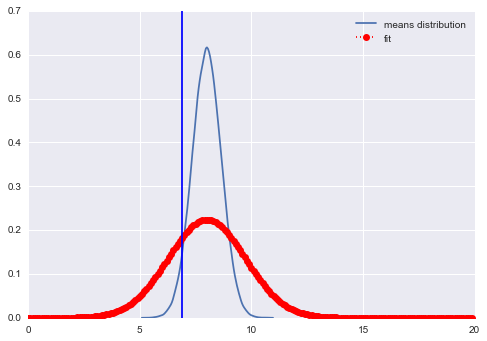

In [18]:
meanNs = []
for ii in np.arange(1e5):
    rvs = np.random.normal(loc=popt[1],scale=popt[2],size=a.size)
    meanNs.append(rvs.mean())
meansKDE = sm.nonparametric.KDEUnivariate(meanNs)
meansKDE.fit('gau', bw='scott', gridsize=100, cut=3, clip=[0,100])
pl.plot(meansKDE.support,meansKDE.density,label='means distribution')
pl.plot(x,gaus(x,*popt),'ro:',label='fit')
pl.axvline(a.mean())
pl.legend()

In [19]:
np.sum(meansKDE.evaluate(np.arange(0,a.mean(),0.01))*0.01)

0.045177716978908544

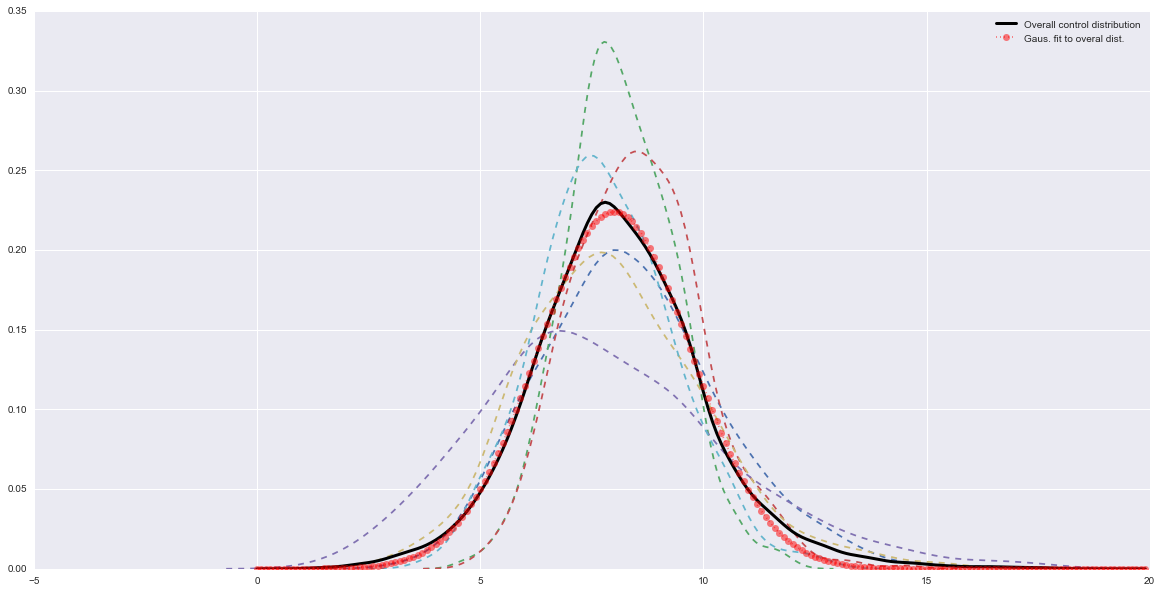

In [58]:
f,ax = pl.subplots(1,1,figsize=[20,10])
for item in rrrList:
    ratios = pkl.load(open(item,'rb'))
    dens = sm.nonparametric.KDEUnivariate(ratios)
    dens.fit('gau', bw='scott', gridsize=100, cut=3, clip=[0,100])
    pl.plot(dens.support,dens.density,'--')
pl.plot(x,y,'k',lw=3,label='Overall control distribution')
#pl.plot(meansKDE.support,meansKDE.density,c='c',lw=3,label='Distribution of means')
pl.plot(x,gaus(x,*popt),'ro:',alpha=0.5,label='Gaus. fit to overal dist.')
pl.legend()

In [13]:
rrrList

['/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3837Lesion/3837.rrr',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3838Lesion/3838.rrr',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3656Lesion/3656.rrr',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3754Lesion/3754.rrr',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat405Lesion/405.rrr',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3903Lesion/3903.rrr']